In [1]:
import pandas as pd


In [2]:
!unzip fraudTrain.csv.zip

Archive:  fraudTrain.csv.zip
replace fraudTrain.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [36]:
df = pd.read_csv("/content/fraudTrain.csv")

In [37]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [38]:
df.isnull().sum()  # Gets the sum of empty rows in the columns

,0
Unnamed: 0,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [401]:
def preprocess_fraud_data(df):
    # Drop redundant columns in place
    df.drop(columns=["Unnamed: 0","trans_num"], inplace=True, errors="ignore")

    # Extract year of birth and compute age
    df["year"] = df["dob"].str.split("-").str[0]
    df["age"] = 2025 - df["year"].astype(int)

    # Convert transaction time to datetime and extract features
    df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
    df["hour"] = df["trans_date_trans_time"].dt.hour
    df["weekday"] = df["trans_date_trans_time"].dt.weekday
    df["month"] = df["trans_date_trans_time"].dt.month

    # Drop columns
    df.drop(columns=[
        "year", "dob", "zip", "street", "first", "last", "cc_num",
        "city_pop", "trans_date_trans_time", "unix_time"
    ], inplace=True, errors="ignore")

    # Haversine distance
    def haversine(lat1, lon1, lat2, lon2):
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        r = 6371
        return c * r

    df["distance_km"] = haversine(df["lat"], df["long"], df["merch_lat"], df["merch_long"])
    df.drop(columns=["lat", "long", "merch_lat", "merch_long", "merchant"], inplace=True, errors="ignore")

    # Channel column
    pos_categories = ["gas_transport", "grocery_pos", "shopping_pos", "misc_pos"]
    online_categories = ["shopping_net", "misc_net", "grocery_net"]
    df["channel"] = df["category"].apply(
        lambda x: "POS" if x in pos_categories else ("Online" if x in online_categories else "Other")
    )

    # Category cleanup - Revised to match training data processing order
    # Step 1: Apply specific replacements (excluding 'misc' to 'other' for now)
    replacements_step1 = {
        "personal_care": "personal care",
        "food_dining": "food",
        "health_fitness": "health fitness",
        "gas_transport": "gas"
        # 'kids_pet' to 'pet' was in original training replacement, but 'kids_pets' existed. Keeping 'kids_pets' as is.
        # 'misc' to 'other' handled in step 3
    }
    df["category"] = df["category"].replace(replacements_step1)

    # Step 2: Remove '_pos' and '_net'
    df["category"] = df["category"].apply(lambda x: x.replace("_pos", "").replace("_net", ""))

    # Step 3: Replace 'misc' with 'other' (this needs to happen AFTER _pos/_net removal)
    df["category"] = df["category"].replace({"misc": "other"})

    # Drop job column
    df.drop(columns=["job"], inplace=True, errors="ignore")

    categorical = ["category","gender","city","state","channel"]
    numerical = ["amt", "age","hour","weekday","month","distance_km"]

    return categorical, numerical

In [ ]:
preprocess_fraud_data(df)  # Drops and clean up some columns

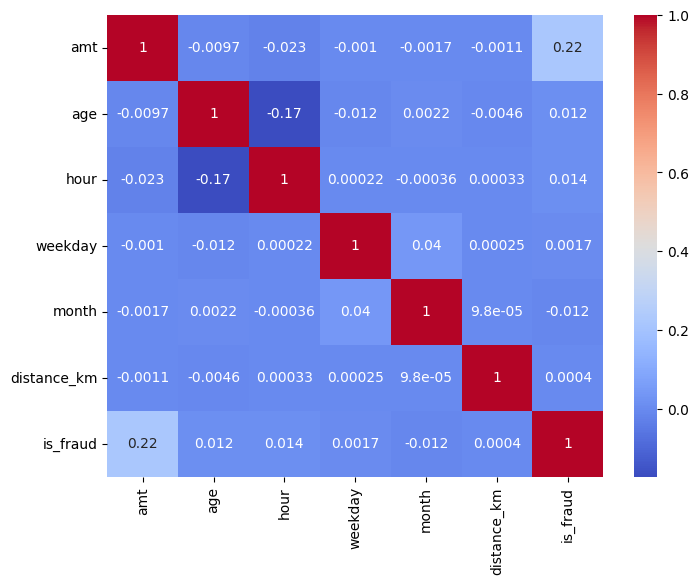

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# select numeric features
numeric_cols = ["amt", "age", "hour", "weekday", "month", "distance_km", "is_fraud"]

# compute correlation
corr = df[numeric_cols].corr()

# plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()


In [48]:
df.drop(columns=["lat", "long", "merch_lat", "merch_long"], inplace=True)

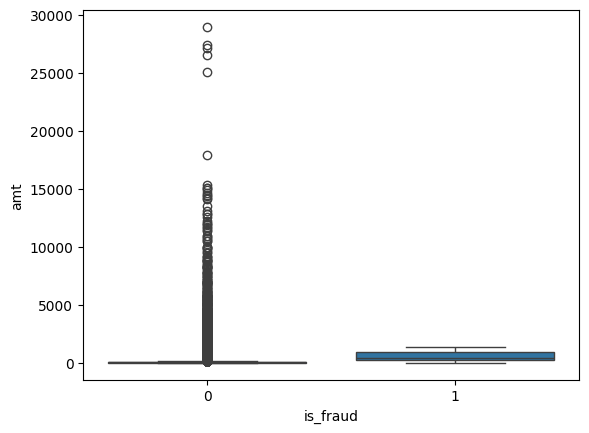

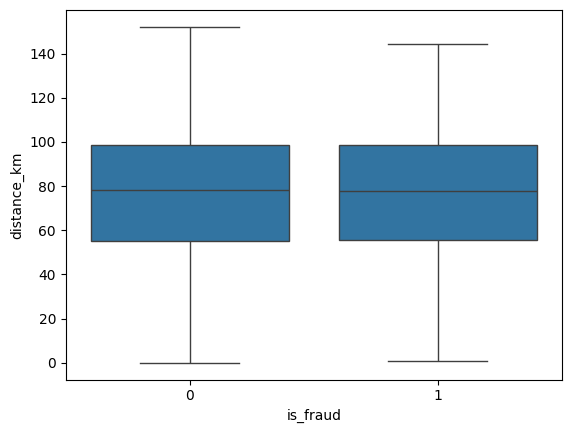

In [49]:
sns.boxplot(x="is_fraud", y="amt", data=df)
plt.show()

sns.boxplot(x="is_fraud", y="distance_km", data=df)
plt.show()


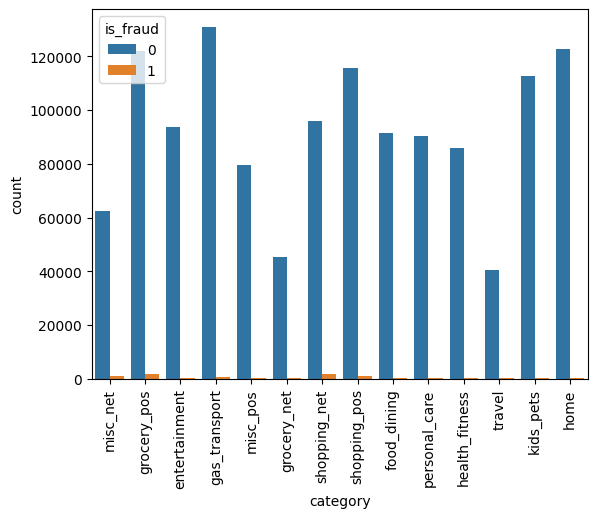

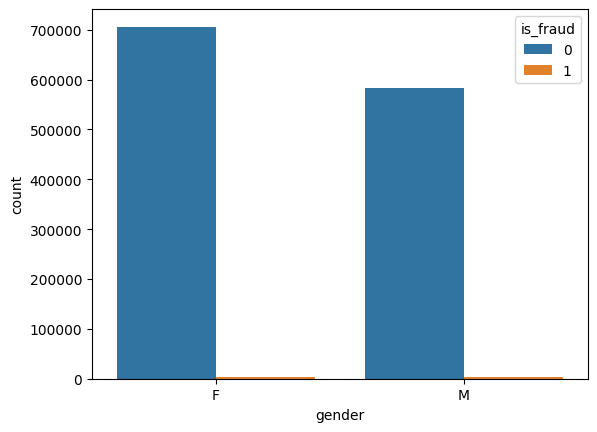

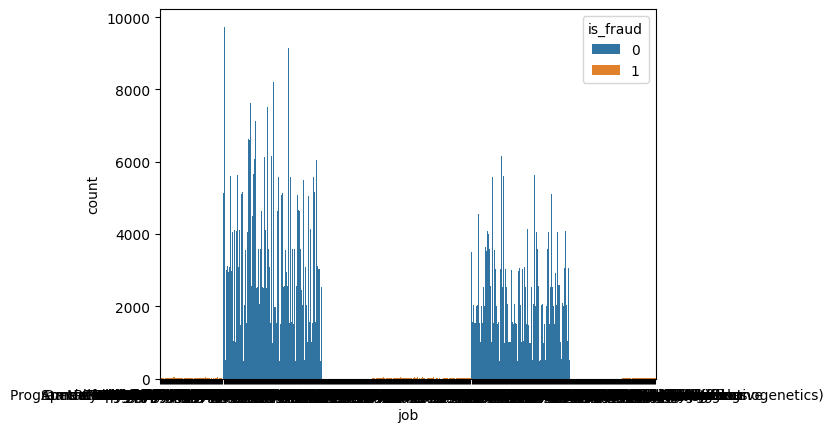

In [50]:
sns.countplot(x="category", hue="is_fraud", data=df)
plt.xticks(rotation=90)
plt.show()

sns.countplot(x="gender", hue="is_fraud", data=df)
plt.show()

In [52]:
df["category"].value_counts()

,count
category,
gas_transport,131659
grocery_pos,123638
home,123115
shopping_pos,116672
kids_pets,113035
shopping_net,97543
entertainment,94014
food_dining,91461
personal_care,90758


In [53]:
df.groupby("category")["is_fraud"].mean().sort_values(ascending=False)*100  # Check for fraud rate per category

,is_fraud
category,
shopping_net,1.756149
misc_net,1.445795
grocery_pos,1.409761
shopping_pos,0.722538
gas_transport,0.469394
misc_pos,0.313853
grocery_net,0.294817
travel,0.286370
entertainment,0.247835


In [118]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  OneHotEncoder
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost import XGBClassifier

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   category     1296675 non-null  object 
 1   amt          1296675 non-null  float64
 2   gender       1296675 non-null  object 
 3   city         1296675 non-null  object 
 4   state        1296675 non-null  object 
 5   job          1296675 non-null  object 
 6   is_fraud     1296675 non-null  int64  
 7   age          1296675 non-null  int64  
 8   hour         1296675 non-null  int32  
 9   weekday      1296675 non-null  int32  
 10  month        1296675 non-null  int32  
 11  distance_km  1296675 non-null  float64
 12  channel      1296675 non-null  object 
dtypes: float64(2), int32(3), int64(2), object(6)
memory usage: 113.8+ MB


In [333]:
categorical = ["category","gender","city","state","channel"]
numerical = ["amt", "age","hour",	"weekday", "month", "distance_km"]

In [63]:
X = df.drop("is_fraud", axis=1)   # features
y = df["is_fraud"]                # target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [409]:
preprocessor = ColumnTransformer(
    transformers= [
        ("num", StandardScaler(), numerical),
        ("cat", OneHotEncoder(drop="first", handle_unknown='ignore'), categorical)
    ],
    remainder="drop"
)

In [410]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Fit and transform X_train using the preprocessor to convert categorical features to numerical
X_train_transformed = preprocessor.fit_transform(X_train)

# Now apply SMOTE to the numerically transformed data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

In [411]:
model = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(
    n_estimators=200,
    max_depth=15,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'))
])

In [412]:
model.fit(X_train, y_train)
supervised_probs = model.predict_proba(X_test)[:,1]  # fraud probability

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [413]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression

# preprocess data for IsolationForest (which doesn't have a preprocessor in its pipeline)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# ----------------------------
# supervised model probabilities
# The 'model' pipeline already contains the preprocessor.
# So, we pass the original X_train and X_test here.
# ----------------------------
probs_train = model.predict_proba(X_train)[:, 1]
probs_test = model.predict_proba(X_test)[:, 1]

# ----------------------------
# isolation forest
# train only on normal class (label = 0)
# ----------------------------
iso = IsolationForest(random_state=42, n_jobs=-1)
iso.fit(X_train_processed[y_train.values == 0])

scores_train = iso.decision_function(X_train_processed)
scores_test = iso.decision_function(X_test_processed)

# ----------------------------
# meta-model dataset
# ----------------------------
X_meta_train = np.column_stack((probs_train, scores_train))
X_meta_test = np.column_stack((probs_test, scores_test))

# ----------------------------
# meta-model
# ----------------------------
meta_model = LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42)
meta_model.fit(X_meta_train, y_train)

# ----------------------------
# final predictions
# ----------------------------
final_preds = meta_model.predict(X_meta_test)

In [425]:
from sklearn.metrics import roc_auc_score
final_probs = meta_model.predict_proba(X_meta_test)[:, 1]

print(roc_auc_score(y_test, final_probs))

Meta-model saved as meta_model.joblib
Preprocessor saved as preprocessor.joblib


In [415]:
from sklearn.metrics import confusion_matrix
# Convert probabilities to binary predictions using a threshold of 0.2
binary_preds = (final_probs > 0.9).astype(int)
print(confusion_matrix(y_test, binary_preds))

[[257470    364]
 [   153   1348]]


In [426]:
import joblib

# Save the meta_model
joblib.dump(meta_model, 'Fraud_detection_model.pkl')
print("Meta-model saved as Fraud_detection_model.pkl")

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Preprocessor saved as preprocessor.pkl")

Meta-model saved as Fraud_detection_model.pkl
Preprocessor saved as preprocessor.pkl


In [433]:
joblib.dump(model, "model.pkl")

['model.pkl']

In [416]:


from sklearn.metrics import classification_report
print(classification_report(y_test, binary_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.79      0.90      0.84      1501

    accuracy                           1.00    259335
   macro avg       0.89      0.95      0.92    259335
weighted avg       1.00      1.00      1.00    259335



In [328]:
!unzip fraudTest.csv.zip

Archive:  fraudTest.csv.zip
replace fraudTest.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fraudTest.csv           


In [427]:
joblib.dump(iso, "iso_model.pkl")

['iso_model.pkl']

In [399]:
pred_test = pd.read_csv("/content/fraudTest.csv")

In [400]:
pred_test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [402]:
preprocess_fraud_data(pred_test)

(['category', 'gender', 'city', 'state', 'channel'],
 ['amt', 'age', 'hour', 'weekday', 'month', 'distance_km'])

In [382]:
pred_test.head()

,category,amt,gender,city,state,is_fraud,age,hour,weekday,month,distance_km,channel
0,personal care,2.86,M,Columbia,SC,0,57,12,6,6,24.561462,Other
1,personal care,29.84,F,Altonah,UT,0,35,12,6,6,104.925092,Other
2,health fitness,41.28,F,Bellmore,NY,0,55,12,6,6,59.080078,Other
3,misc,60.05,M,Titusville,FL,0,38,12,6,6,27.698567,POS
4,travel,3.19,M,Falmouth,MI,0,70,12,6,6,104.335106,Other


In [403]:
categorical = ["category","gender","city","state","channel"]
numerical = ["amt", "age","hour",	"weekday", "month", "distance_km"]
preprocessor = ColumnTransformer(
    transformers= [
        ("num", StandardScaler(), numerical),
        ("cat", OneHotEncoder(drop="first"), categorical)
    ],
    remainder="drop"
)

In [421]:
# Prepare the new test data (pred_test) for prediction
X_new_test = pred_test.drop("is_fraud", axis=1)
y_new_test_true = pred_test["is_fraud"] # Extract true labels for the new test data

In [405]:
pred_test["category"].value_counts()

,count
category,
shopping,91570
grocery,71979
other,61941
gas,56370
home,52345
kids_pets,48692
entertainment,40104
personal care,39327
food,39268


In [417]:
# 1. Transform X_new_test using the preprocessor for IsolationForest
# X_new_test_processed = preprocessor.transform(X_new_test) # This line was commented out in user's last edit, keep it that way for this step.

# 2. Get supervised model probabilities for X_new_test
# The 'model' pipeline already contains the preprocessor, so pass original X_new_test
new_probs = model.predict_proba(X_new_test)[:, 1]

# 3. Get unsupervised scores for X_new_test_processed
# Note: iso.decision_function expects processed numerical data. If preprocessor is not used before, this will fail.
# Re-introducing the X_new_test_processed for iso.decision_function, and ensuring preprocessor is fitted.
# If preprocessor is fitted, X_new_test_processed should be used for iso model
# If preprocessor is part of 'model' pipeline, then original X_new_test should be used.
# Given 'model' contains preprocessor, and iso is separate, we need preprocessor.transform for iso.

X_new_test_processed = preprocessor.transform(X_new_test) # Re-introducing this line
new_scores = iso.decision_function(X_new_test_processed)

# 4. Create meta-model input for the new test data
X_meta_new_test = np.column_stack((new_probs, new_scores))

# 5. Make final predictions using the meta-model
final_preds = meta_model.predict(X_meta_new_test)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [418]:
print(final_preds)

[0 0 0 ... 0 0 0]


In [422]:
from sklearn.metrics import roc_auc_score


print(roc_auc_score(y_new_test_true, final_probs))

0.9944374088604128


In [424]:
from sklearn.metrics import classification_report
print(classification_report(y_new_test_true, final_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.66      0.83      0.74      2145

    accuracy                           1.00    555719
   macro avg       0.83      0.92      0.87    555719
weighted avg       1.00      1.00      1.00    555719



In [ ]:
import joblib
